In [1]:
!git clone https://github.com/polimi-ispl/icpr2020dfdc
!pip install efficientnet-pytorch
!pip install -U git+https://github.com/albu/albumentations > /dev/null
%cd icpr2020dfdc/notebook

Cloning into 'icpr2020dfdc'...
remote: Enumerating objects: 645, done.
remote: Counting objects: 100% (645/645), done.
remote: Compressing objects: 100% (564/564), done.
remote: Total 645 (delta 333), reused 329 (delta 49), pack-reused 0
Receiving objects: 100% (645/645), 99.63 MiB | 44.63 MiB/s, done.
Resolving deltas: 100% (333/333), done.
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=d266c6725e5af1b60921ab46cd1767886ce9615e71f76b0140ea16ad686c6fd5
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-8a4xriht
/content/icpr2020dfdc/notebook


In [2]:
import torch
from torch.utils.model_zoo import load_url
import matplotlib.pyplot as plt
from scipy.special import expit

import os

import sys
sys.path.append('..')

from blazeface import FaceExtractor, BlazeFace, VideoReader
from architectures import fornet,weights
from isplutils import utils

In [3]:
"""
Choose an architecture between
- EfficientNetB4
- EfficientNetB4ST
- EfficientNetAutoAttB4
- EfficientNetAutoAttB4ST
- Xception
"""
net_model = 'EfficientNetAutoAttB4'

"""
Choose a training dataset between
- DFDC
- FFPP
"""
train_db = 'DFDC'

In [4]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
face_policy = 'scale'
face_size = 224
frames_per_video = 32

In [5]:
model_url = weights.weight_url['{:s}_{:s}'.format(net_model,train_db)]
net = getattr(fornet,net_model)().eval().to(device)
net.load_state_dict(load_url(model_url,map_location=device,check_hash=True))

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth


  0%|          | 0.00/74.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b4


Downloading: "https://f002.backblazeb2.com/file/icpr2020/EfficientNetAutoAttB4_DFDC_bestval-72ed969b2a395fffe11a0d5bf0a635e7260ba2588c28683630d97ff7153389fc.pth" to /root/.cache/torch/hub/checkpoints/EfficientNetAutoAttB4_DFDC_bestval-72ed969b2a395fffe11a0d5bf0a635e7260ba2588c28683630d97ff7153389fc.pth


  0%|          | 0.00/33.9M [00:00<?, ?B/s]

<All keys matched successfully>

In [6]:
transf = utils.get_transformer(face_policy, face_size, net.get_normalizer(), train=False)

In [7]:
facedet = BlazeFace().to(device)
facedet.load_weights("../blazeface/blazeface.pth")
facedet.load_anchors("../blazeface/anchors.npy")
videoreader = VideoReader(verbose=False)
video_read_fn = lambda x: videoreader.read_frames(x, num_frames=frames_per_video)
face_extractor = FaceExtractor(video_read_fn=video_read_fn,facedet=facedet)

In [23]:
#!mkdir data

from google.colab import files
#files.upload()
model_path = '/content/simswap_result.mp4'

In [27]:
vid_fake_faces = face_extractor.process_video(model_path)

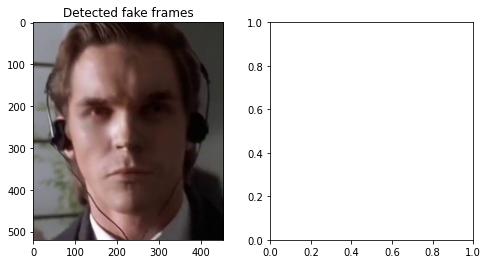

In [62]:
im_fake_face = vid_fake_faces[15]['faces'][0]
fig,ax = plt.subplots(1, 2, figsize=(8,4))

ax[0].imshow(im_fake_face)
ax[0].set_title('Detected fake frames');

In [29]:
# For each frame, we consider the face with the highest confidence score found by BlazeFace (= frame['faces'][0])
faces_fake_t = torch.stack( [ transf(image=frame['faces'][0])['image'] for frame in vid_fake_faces if len(frame['faces'])] )

with torch.no_grad():
    faces_fake_pred = net(faces_fake_t.to(device)).cpu().numpy().flatten()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  


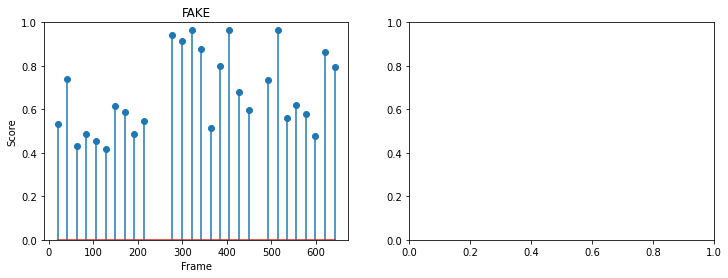

In [34]:
fig,ax = plt.subplots(1, 2, figsize=(12,4))

ax[0].stem([f['frame_idx'] for f in vid_fake_faces if len(f['faces'])],expit(faces_fake_pred),use_line_collection=True)
ax[0].set_title('FAKE')
ax[0].set_xlabel('Frame')
ax[0].set_ylabel('Score')
ax[0].set_ylim([0,1])
ax[0].set_yticks([0,1],['REAL','FAKE']);

In [35]:
"""
Print average scores.
An average score close to 0 predicts REAL. An average score close to 1 predicts FAKE.
"""
print('Average score for FAKE face: {:.4f}'.format(expit(faces_fake_pred.mean())))

Average score for FAKE face: 0.7248
